### ohne hems


In [9]:
import pandas as pd
import importlib
import berechnen_wp, pv_profil, lastprofile_VDI4655, temperatur_aussen, try_region, heizkurve
importlib.reload(berechnen_wp)
importlib.reload(heizkurve)

h, w, twe, s = lastprofile_VDI4655.get_jahresenergiebedarf('1984 - 1994', 200, 3, 0)
TRY_region, T_n_aussen = try_region.get_try_t_n_aussen(40599)
df = lastprofile_VDI4655.get_lastprofile(w, s, twe, 200, TRY_region, 3)
df['T_aussen'] = temperatur_aussen.get_hourly_temperature(40599, 2014)
hz, T_soll, T_n_vor, T_n_rueck = heizkurve.get_heizkurve('Heizkörper', df['T_aussen'], T_n_aussen)
df['T_vor'] = hz['T_vor']
df['T_rueck'] = hz['T_rueck']
wp_groesse, nenn_heizleistung = berechnen_wp.get_waermepumpe(h)
heizleistung_auslegung = heizkurve.get_heizleistung(T_n_aussen, h, T_soll)
df = heizkurve.get_heizleistung_profil(df, heizleistung_auslegung)
df = heizkurve.get_cop(wp_groesse, df)
V_ps, PS_verlust, Q_ps = berechnen_wp.get_pufferspeicher(h, T_n_vor, T_n_rueck)
# df, P_el, COP = berechnen_wp.ohne_pv(df, Q_ps, PS_verlust)
# pv = pv_profil.get_pv_profil(40599, 2014, 10)
# df_pv = berechnen_wp.mit_pv(df.copy(), pv)
# df_pvbs = berechnen_wp.mit_pvbs(df.copy(), pv, 10, 11)

In [14]:
importlib.reload(berechnen_wp)
df_ohne, P_el, COP = berechnen_wp.ohne_pv(df.copy(), Q_ps, PS_verlust, nenn_heizleistung)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




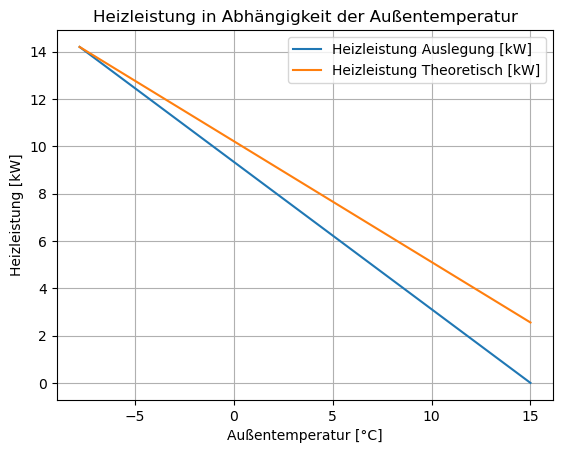

<module 'matplotlib.pyplot' from 'c:\\Users\\n-w\\anaconda3\\envs\\thesis_venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline
heizkurve.plot_heizleistung(heizleistung_auslegung)

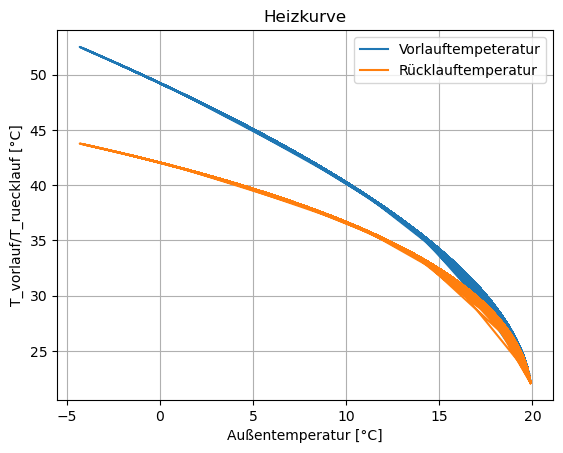

<module 'matplotlib.pyplot' from 'c:\\Users\\n-w\\anaconda3\\envs\\thesis_venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [12]:
%matplotlib inline
heizkurve.plot_heizkurve(hz)

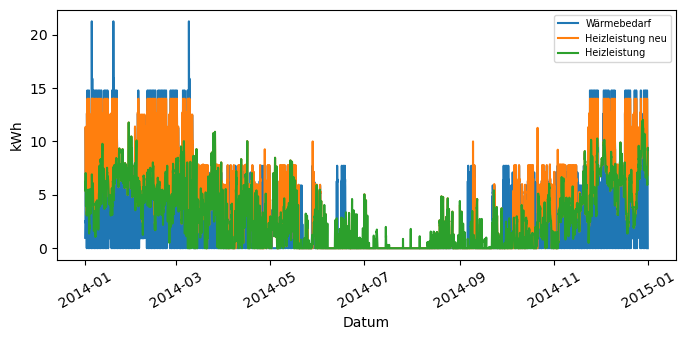

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Wärmebedarf")
plt.plot(df_ohne.index, df_ohne['Heizleistung neu'], label = "Heizleistung neu")
plt.plot(df_ohne.index, df_ohne['Heizleistung'], label = "Heizleistung")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 7, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-11-03 00:00:00'), pd.Timestamp('2014-11-06 23:00:00')) 
plt.show()

In [2]:
pv = pv_profil.get_pv_profil(40599, 2014, 10)
df_pv = berechnen_wp.mit_pv(df.copy(), pv)
df_pvbs = berechnen_wp.mit_pvbs(df.copy(), pv, 10, 11)

In [ ]:
importlib.reload(berechnen_wp)
strompreis = 0.358
ergebnisse_pv = berechnen_wp.ersparnis_pv(df_pv, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_pv)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_bs = berechnen_wp.ersparnis_bs(df_pvbs, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_bs)

In [5]:
importlib.reload(berechnen_wp)
df_ev = berechnen_wp.mit_pvev(df.copy(), pv, True)

In [6]:
importlib.reload(berechnen_wp)
df_pvbsev = berechnen_wp.mit_pvbsev(df.copy(), pv, 10, 11, True)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_ev = berechnen_wp.ersparnis_ev(df_ev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_ev)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_evbs = berechnen_wp.ersparnis_evbs(df_pvbsev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_evbs)

## mit HEMS

In [ ]:
Q_ps

In [ ]:
dichte = 1 # kg/m^3
c_wasser = 4.18 # kJ/(kg·K)
Q_ps_n = 10.69
V_ps_n = round(Q_ps_n/(dichte*c_wasser*(55 - 45)/3600), 3)
V_ps_n

In [ ]:
round(3.48/(dichte*c_wasser*(55 - 45)/3600), 3)


In [ ]:
1.52/24

In [ ]:
3.583-1.875

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
heizkurve.plot_heizleistung(heizleistung_auslegung)

In [ ]:
df['Heizleistung'].max()